#  12. Solidity 결합, 라이브러리, 보안

* Last Updated 20200617WED1000 20190605WEB1200 20190120SUN0000 20180707SAT1300 20170112

## 12.1 학습내용

### 12.1.1 목표
 
* contract 결합, 상속, 라이브러리, 보안

### 12.1.2 목차

* 12.2 컨트랙 결합
    * 12.2.1 상대측 객체의 생성
    * 12.2.2 함수의 호출
    * 실습: new 명령어로 컨트랙 생성
    * 실습: 컨트랙의 주소를 사용하여 컨트랙 결합
    * 실습: 자동차와 엔진 컨트랙: new 명령어 사용
    * 실습: 사각형과 면적 컨트랙: new 명령어 사용
    * 실습: 이미 배포된 컨트랙을 포함: 주소를 사용
    * 실습: import 문을 사용하여 컨트랙 결합
    * 문제: Observer pattern
* 12.3 [상속](#12.3)
    * 실습: greeter
* 12.4 [Library](#12.4)
    * 12.4.1 library internal
    * 실습: 주소 없이 라이브러리 사용
    * 12.4.2 library public
    * 실습: 커맨드라인으로 라이브러리 링크
    * 실습: placeholder에 주소를 넣어 라이브러리 링크
    
    * 실습: 제삼자가 제공하는 github 라이브러리
    * 실습: OpenZeppelin
* 12.5 [보안](#12.5)


## 12.2 컨트랙 결합

지금까지는 주로 하나의 컨트랙을 개발하였다. 컨트랙이 2개 이상이 되는 경우, 결합을 해야 한다. Solidity는 객체지향언어이므로 ```is-a```, ```has-a``` 관계를 구현할 수 있다.

### 12.2.1 상대측 객체의 생성

컨트랙이 결합해야 하는 경우, 먼저 상대 객체를 생성해야 한다.
사용하려는 대상 객체는, 
* 배포되어 있지 않은 경우 또는
* 배포되어 있는 경우로 구분하여 관계를 가질 수 있다.

#### 배포되어 있지 않은 경우
* 한 파일에 컨트랙의 소스코드가 포함되는 경우, ```new()``` 명령어로 **인스턴스**를 만들어서 함수를 호출한다.

#### 배포되어 있는 경우
* 이미 배포된 컨트랙을 포함되는 경우, **주소**를 구해서 넘겨주어야 한다.

상대객체를 한 파일에 포함하지 않는 경우라면, ```import``` 문으로 그 컨트랙을 포함하여야 한다.
```import```문 다음에 적는 filename은 **현재 프로그램의 상대경로**로 적어준다.

```python
import <<filename>>
```


### 12.2.2 함수의 호출

#### 컨트랙에서 호출
상대측 객체를 만들고 나면, 함수를 호출한다.
함수는 객체지향에서 하는 방식으로 dot operator를 사용하면 된다.
```python
<instance>.functionMethod()
```

#### ```webe.js```에서 호출
```web3.js```에서는 ```<instance>.methods.functionMethod()```라고 호출한다.

좀 더 자세히 설명하면, 앞서 ```5.2 ABI 명세```에서 설명하였던 ```function selector```를 사용하여 함수가 호출된다.
```function setCounter(uint n){ counter = n; }``` 함수를 컨트랙에서 호출해 보자.
함수명을 sha3 해싱한 후, 처음 4바이트로 함수를 호출하게 된다.
데이터가 없는 경우 (```calldata```가 없는 경우), ```fallback``` 함수가 호출된다.

힘수 호출 | 설명
-----|-----
<address>.call.gas(200000).value(this.balance)("") | fallback 함수 호출
<address>.call.gas(200000).value(this.balance)(bytes4(bytes32(sha3("setCounter(uint)")))) | ```setCounter``` 함수 호출

다른 컨트랙을 호출하는 경우 gas 비용이 infinite라고 계산된다. 그 이유는 다른 컨트랙이 얼마나 gas를 사용하게 될지 모르기 때문이다.
gas비용은 전송측에서 차감이 된다는 점에 주의하자.



## 실습: new 명령어로 컨트랙 생성

```new()``` 명령어로 컨트랙을 생성하려면 컴파일 시점에 그 소스코드를 가져올 수 있어야 한다.
즉 **상대 컨트랙이 동일한 파일에 존재**하거나
또는 **```import``` 문으로 상대 컨트랙이 포함**되는 경우가 해당이 된다.
그러면 상대 컨트랙이 컴파일되어 바이트코드가 포함되게 된다.

In [1]:
import iplantuml

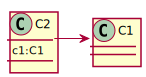

In [2]:
%%plantuml --jar
@startuml
class C1
class C2 {
    c1:C1
}
C2->C1
@enduml

### 단계 1: 컨트랙 개발

일부 0.5버전에서는 컴파일은 문제가 없었으나, 실행하면 기대하는 기능을 수행하지 못하는 증상이 있었다. 이는 이미 개발자들이 이슈에서 제기한 바, 0.4.21이하에서는 문제가 없으나 그 이후에는 문제가 있다 (https://github.com/ethereum/solidity/issues/3969).


In [32]:
%%writefile src/C1C2.sol
pragma solidity ^0.6;
//pragma solidity 0.4.21;
contract C1 {
    uint128 v1;
    function set(uint128 _v1) public {
        v1=_v1;
    }
    function get() public view returns(uint128) {
        return v1;
    }
    function get7() public pure returns(uint128) {
        return 7;
    }
}

contract C2 {
    C1 c1;
    //function C2() public {  //0.4.21 constructor
    constructor() public {    //0.6 constructor
        c1=new C1();
    }
    function set(uint128 _v1) public {
        c1.set(_v1);
    }
    function get() public view returns(uint128) {
        return c1.get();
    }
    function get7() public view returns(uint128) {
        return c1.get7();
    }
    function getC1Address() public view returns(address) {
        return address(c1);
    }
}

Overwriting src/C1C2.sol


### 단계 2: 컴파일

다음과 같이 컴파일할 수 있다.
로컬에서 설치된 solc보다 낮은 버전으로 컴파일 하려면 REMIX에서 버전을 낮추어 컴파일하고 ABI, bin을 가져온다.
파일에 컨트랙이 2개 있으면, 컴파일한 ABI, bin도 2개가 생성된다.

In [28]:
!solc src/C1C2.sol --combined-json abi,bin > src/C1C2.json

### 단계 3: 배포

컴파일 한 후, C2의 abi, bin을 가져와서 배포를 한다.

In [15]:
%%writefile src/C1C2Deploy.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C1C2.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/C1C2.sol:C2"].abi);
//var _bin=_json.contracts.sHello2.bin;
var _bin="0x"+_json.contracts["src/C1C2.sol:C2"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash"+hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR "+error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}
deploy()

Overwriting src/C1C2Deploy.js


In [1]:
!node src/C1C2Deploy.js

Deploying the contract from 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
>>> transactionHash0x2188f922e7158e4b24f754886a53b1a216d7249ec4959217341acb1833cf161d
>>> RECEPIT hash: 0x2188f922e7158e4b24f754886a53b1a216d7249ec4959217341acb1833cf161d
>>> address:0x83AA5DdD047fD1B931480A6A1557F6feb54Dec8b
---> The contract deployed to: 0x83AA5DdD047fD1B931480A6A1557F6feb54Dec8b


### 단계 4: 사용

In [2]:
%%writefile src/C1C2Use.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C1C2.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/C1C2.sol:C2"].abi);

var c2 = new web3.eth.Contract(_abiArray, "0x83AA5DdD047fD1B931480A6A1557F6feb54Dec8b");

async function doIt() {
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    c2.methods.get7().call().then(console.log);
    await c2.methods.set(9).send({from: accounts[0],gas:50000});
    c2.methods.get().call().then(console.log);
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
    //hello.methods.kill().send({from: accounts[0]})
}

doIt()


Overwriting src/C1C2Use.js


In [3]:
!node src/C1C2Use.js

Account: 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
Balance before: 99990295100000000000
7
9
Balance after: 99989414760000000000
Balance diff: 880339999997952


## 실습: 컨트랙의 주소를 사용하여 컨트랙 결합

앞서 ```new()``` 명령어는 소스코드를 포함할 수 있는 경우에 사용하였다.
이번에는 이미 배포된 컨트랙을 결합하여 보자. 그렇다면 C2에 C1의 주소를 넘겨주어야 한다. 즉 C1을 배포하고 그 주소를 알야야 한다.

### C1을 배포하고 주소를 구하기

* 단계 1: 컨트랙 개발 (C1)

In [7]:
%%writefile src/C1.sol
pragma solidity ^0.6;
//pragma solidity 0.4.21;

contract C1 {
    uint128 v1;
    function set(uint128 _v1) public {
        v1=_v1;
    }
    function get() public view returns(uint128) {
        return v1;
    }
    function get7() public pure returns(uint128) {
        return 7;
    }
}

Overwriting src/C1.sol


* 단계 2: 컴파일 (C1)

REMIX에서 0.4.21로 컴파일한 후

byzantium이 기본.
solc --evm-version "homestead" --gas C1.sol

In [8]:
!solc src/C1.sol --combined-json abi,bin > src/C1.json

In [9]:
!cat src/C1.json

{"contracts":{"src/C1.sol:C1":{"abi":"[{\"inputs\":[],\"name\":\"get\",\"outputs\":[{\"internalType\":\"uint128\",\"name\":\"\",\"type\":\"uint128\"}],\"stateMutability\":\"view\",\"type\":\"function\"},{\"inputs\":[],\"name\":\"get7\",\"outputs\":[{\"internalType\":\"uint128\",\"name\":\"\",\"type\":\"uint128\"}],\"stateMutability\":\"pure\",\"type\":\"function\"},{\"inputs\":[{\"internalType\":\"uint128\",\"name\":\"_v1\",\"type\":\"uint128\"}],\"name\":\"set\",\"outputs\":[],\"stateMutability\":\"nonpayable\",\"type\":\"function\"}]","bin":"608060405234801561001057600080fd5b506101a9806100206000396000f3fe608060405234801561001057600080fd5b50600436106100415760003560e01c8063086949b7146100465780634178462f146100885780636d4ce63c146100c8575b600080fd5b61004e61010a565b60405180826fffffffffffffffffffffffffffffffff166fffffffffffffffffffffffffffffffff16815260200191505060405180910390f35b6100c66004803603602081101561009e57600080fd5b8101908080356fffffffffffffffffffffffffffffffff1690602001909291905050

* 배포 (C1)

In [11]:
%%writefile src/C1Deploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C1.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/C1.sol:C1"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x"+_json.contracts["src/C1.sol:C1"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash" + hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR " + error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}
deploy()


Overwriting src/C1Deploy.js


C1Deploy.js를 한 줄씩 REPL할 수 있다. Mac에서 해보니 이유없이 ```Returned error: unknown account``` 오류를 발생하고 있다.

In [12]:
!node src/C1Deploy.js

Deploying the contract from 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
>>> transactionHash0x2b3ee36d75725837b00f422b23dd5db801e8c6d39a70a60cb117b041624acbb4
>>> RECEPIT hash: 0x2b3ee36d75725837b00f422b23dd5db801e8c6d39a70a60cb117b041624acbb4
>>> address:0xc71cC556bf5C9c4694062BF4752768F65d9349Dc
---> The contract deployed to: 0xc71cC556bf5C9c4694062BF4752768F65d9349Dc


* 사용 (C1)

위 오류에도 불구하고 nodejs를 REPL로 해서 주소를 얻어서 복사해 넣고 아래를 실행하면 결과를 얻을 수 있다.

In [15]:
%%writefile src/C1Use.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C1.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/C1.sol:C1"].abi);

var c1 = new web3.eth.Contract(_abiArray, "0xc71cC556bf5C9c4694062BF4752768F65d9349Dc");
async function doIt() {
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    c1.methods.get7().call().then(console.log);
    await c1.methods.set(9).send({from: accounts[0],gas:50000});
    c1.methods.get().call().then(console.log);
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
    //hello.methods.kill().send({from: accounts[0]})
}

doIt()


Overwriting src/C1Use.js


In [16]:
!node src/C1Use.js

Account: 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
Balance before: 99986065100000000000
7
9
Balance after: 99985225800000000000
Balance diff: 839300000006144


### 단계 1: 컨트랙 개발 (C2)

```C1```과 ```C2```를 결합하는 소스코드를 구현해보자.
```C1```은 이미 배포가 되었고, 그 주소를 받을 수 있는 기능이 필요하다.
이 경우 ```C1```의 abi를 모르면 ```C2```를 컴파일을 할 수 없다.
예를 들어 ```C1```의 함수 ```c1.get7()```를 모르면, C2의 ```get7()```을 컴파일 할 수 없게 된다.

앞서 ```C1.sol```, ```C2.sol```을 한 파일 안에 적어주지 않고,
```import```문으로 ```C1```을 포함한다.
이 경우 ```import C1.sol```이라고 해주지 않고, 현재 파일의 상대 디렉토리 ```import "./C1.sol"```로 적어준다.

구분 | 사용 예 | 이유
-----|-----|-----
올바른 사용 | ```import "./C1.sol"``` | 상대 디렉토리로 적어주면 ```C1.sol```을 못 찾는다.
올바르지 않은 사용 | ```import "C1.sol"``` | 상대 디렉토리가 아니라서 오류가 발생

In [17]:
%%writefile src/C2.sol
pragma solidity 0.6;
//pragma solidity 0.4.21;
import "./C1.sol";

contract C2 {
    C1 c1;
    //function C2() public {  //0.4.21 constructor
    constructor() public {    //0.6 constructor
        c1=new C1();
    }
    function setC1(address _addressOfC1) public {
        c1 = C1(_addressOfC1);
    }
    function set(uint128 _v1) public {
        c1.set(_v1);
    }
    function get() public view returns(uint128) {
        return c1.get();
    }
    function get7() public view returns(uint128) {
        return c1.get7();
    }
    function getC1Address() public view returns(address) {
        return address(c1);
    }
}

Overwriting src/C2.sol


### 단계 2: 컴파일 (C2)

C2를 컴파일한다.

In [18]:
!solc src/C2.sol --combined-json abi,bin > src/C2.json

### 단계 3: 배포

In [20]:
%%writefile src/C2Deploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C2.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/C2.sol:C2"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x"+_json.contracts["src/C2.sol:C2"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash" + hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR " + error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}
deploy()


Overwriting src/C2Deploy.js


In [46]:
!node src/C2Deploy.js

Deploying the contract from 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
>>> transactionHash0xa590fbd70cb5e86b8d80c25212ce83891136d2c4a40aff8952a9916cf81fd049
>>> RECEPIT hash: 0xa590fbd70cb5e86b8d80c25212ce83891136d2c4a40aff8952a9916cf81fd049
>>> address:0xe812078c783942dA662E89acF3351d0Fbf16cF81
---> The contract deployed to: 0xe812078c783942dA662E89acF3351d0Fbf16cF81


### 단계 4: 사용

줄 | 함수 | 설명
-----|-----|-----
16 | ```c2.methods.getC1Address().call()``` | 생성자에서 ```new``` 명령어로 생성된 ```C1```의 주소를 출력. 단, ```C2```를 배포하고 첫 회 실행할 때만 유효하고, 2회부터는 이전에 실행된 ```setC1()```의 결과인 이전 ```C1```의 주소가 출력된다.
19 | ```c2.methods.get7().call()``` | ```await```로 하지 않으면 실행 순서가 늦춰질 수 있다.
21 | c2.methods.setC1() | 생성자에서 설정한 C1을 제거하고, 위에서 블록체인에 배포한 C1의 주소를 사용하여 교체한다.

In [47]:
%%writefile src/C2Use.js
var Web3=require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C2.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/C2.sol:C2"].abi);

var c2 = new web3.eth.Contract(_abiArray, "0xe812078c783942dA662E89acF3351d0Fbf16cF81");
async function doIt() {
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    console.log("--- new C1 ---");
    await c2.methods.getC1Address().call(function(err, c1addr) {
        if(!err) console.log("c1 address by 'new': "+c1addr);
    });
    await c2.methods.get7().call().then(console.log);
    console.log("--- set the above deployed address of C1 ---");
    await c2.methods.setC1("0xc71cC556bf5C9c4694062BF4752768F65d9349Dc").send({from:accounts[0], gas:50000});
    await c2.methods.getC1Address().call(function(err, c1addr) {
        if(!err) console.log("c1 address by 'setC1()': "+c1addr);
    });
    c2.methods.get7().call().then(console.log);
    await c2.methods.set(222).send({from: accounts[0],gas:50000});
    c2.methods.get().call().then(console.log);
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
    //hello.methods.kill().send({from: accounts[0]})
}

doIt()


Overwriting src/C2Use.js


In [48]:
!node src/C2Use.js

Account: 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
Balance before: 99945866560000000000
--- new C1 ---
c1 address by 'new': 0x6BA98F59D5E3dDd9a3A38727e04dFDC4C4bE9D16
7
--- set the above deployed address of C1 ---
c1 address by 'setC1()': 0xc71cC556bf5C9c4694062BF4752768F65d9349Dc
7
222
Balance after: 99944817720000000000
Balance diff: 1048839999995904


2회를 실행하면 아래에서 보는 것처럼 C1의 주소가 같아진다.
2회부터는 이전에 실행된 ```setC1()```의 결과인 이전 ```C1```의 주소로 설정되어 출력된다.
생성자가 최초에만 호출되기 때문이다.

다시 생성자를 호출하여 ```C1```의 주소를 설정하려면, C2를 다시 배포한 후 그 주소로 ```C2Use.js```를 실행하면 된다.

In [49]:
!node src/C2Use.js

Account: 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
Balance before: 99944817720000000000
--- new C1 ---
c1 address by 'new': 0xc71cC556bf5C9c4694062BF4752768F65d9349Dc
7
--- set the above deployed address of C1 ---
c1 address by 'setC1()': 0xc71cC556bf5C9c4694062BF4752768F65d9349Dc
7
222
Balance after: 99943864880000000000
Balance diff: 952839999995904


## 실습: 자동차와 엔진 컨트랙: new 명령어 사용

동일한 파일에 2개의 컨트랙을 넣어서 개발해 보자.

### 단계 1: 컨트랙 개발

Line | 설명
-----|-----
1 | major version 6 이상 최신으로 컴파일
2 | contract 명. 컨트랙이 2개 포함된 경우, 파일명과 반드시 일치할 필요가 없다.
4 | ```Engine```을 포함하고, ```constructor```에서 할당한다.
26 ~ 31 | ```start()```은 ```engineObj.on()``` 엔진을 켠다. 그리고 엔진상태를 이벤트로 발생한다.
52 ~ 60 | ```speed```가 0 ~ 최대속도 범위 내에서 속도를 증감하도록 한다. 감속을 위해 음수를 사용할 수 있도록 ```int```를 적용하면 ```uint```로 형변환이 필요함.

In [15]:
%%writefile src/Car.sol
pragma solidity ^0.6.0;
//pragma solidity 0.4.21;
contract Car {
    Engine engineObj;
    string private color;
    event PrintLog(address sender, string msg);

    constructor() public {
        engineObj = new Engine();
    }
    function setColor(string memory _color) public {
        color=_color;
    }
    function getColor() public view returns(string memory) {
        return color;
    }
    function getSpeed() public view returns(uint) {
        return engineObj.getSpeed();
    }
    function speedUpBy10() public {
        engineObj.setSpeedUpBy(10);
    }
    function speedDownBy10() public {
        engineObj.setSpeedDownBy(10);   
    }
    function start() public {
        engineObj.on();
        //convert bool to string
        string memory engineStateStr=engineObj.getEngineState()? "on" : "off";
        emit PrintLog(msg.sender, engineStateStr);
    }
}

contract Engine {
    uint constant private MAXSPEED = 200;
    uint private speed;
    bool private engineState;

    constructor() public {
        speed = 0;
        off();
    }
    function on() public {
        engineState = true;
    }
    function off() public {
        engineState = false;
    }
    function getEngineState() public view returns(bool){
        return engineState;
    }
    function setSpeedUpBy(uint _speed) public {
        if(speed < (MAXSPEED - 10) && engineState == true)
            speed += _speed;
    }
    // int _speed -> needs casting to uint (speed)
    function setSpeedDownBy(uint _speed) public {
        if((speed - 10) > 0  && engineState == true)
            speed -= _speed;
    }
    function getSpeed() public view returns(uint) {
        return speed;
    }
}

Overwriting src/Car.sol


### 단계 2: 컴파일

현재 설치되어 있는 버전 0.6으로 컴파일 해서, abi, bin을 구한다.
버전이 다른 경우, REMIX에서 컴파일한다.

In [16]:
!solc src/Car.sol --combined-json abi,bin > src/Car.json

### 단계 3: 배포

In [1]:
%%writefile src/carDeploy.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/Car.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/Car.sol:Car"].abi);
//var _bin=_json.contracts.sHello2.bin;
var _bin="0x"+_json.contracts["src/Car.sol:Car"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash"+hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR "+error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}
deploy()


Overwriting src/carDeploy.js


In [2]:
!node src/carDeploy.js

Deploying the contract from 0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E
>>> transactionHash0xf23a81b3f842ebbf385065f238dae116b768ba48c7d8e2b3c87b428ea48ef814
>>> RECEPIT hash: 0xf23a81b3f842ebbf385065f238dae116b768ba48c7d8e2b3c87b428ea48ef814
>>> address:0xd47b1A1c9D52730F6D8c44247241f3CC2786B9E9
---> The contract deployed to: 0xd47b1A1c9D52730F6D8c44247241f3CC2786B9E9


### 단계 4: 사용
아래를 실행하면 다음 결과

```python
> car.getColor.call();
'RED'
```

In [1]:
%%writefile src/carUse.js
var Web3=require('web3');
//var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));         //nok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("http://117.16.44.45:8345"));  //ok
var web3 = new Web3(new Web3.providers.WebsocketProvider("ws://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/Car.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/Car.sol:Car"].abi);

async function doIt() {
    var car = new web3.eth.Contract(_abiArray, "0xd47b1A1c9D52730F6D8c44247241f3CC2786B9E9");
    car.events.PrintLog({fromBlock: 'latest', toBlock:'pending'}, function (error, event) {
            console.log(">>> Event fired: " + JSON.stringify(event.returnValues));
        }).on('>> data', function(event){
            console.log(event); // same results as the optional callback above
        }).on('>> changed', function(event){
            console.log(event); // remove event from local database
        }).on('>> error', console.error);

    var speed;
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    car.methods.setColor("RED").send({from: accounts[0], gas:100000});
    car.methods.getColor().call().then(console.log);
    await car.methods.start().send({from: accounts[0], gas:100000})
    await car.methods.speedUpBy10().send({from: accounts[0], gas:100000})
    car.methods.getSpeed().call().then(function(speed) { console.log("-> speed: " + speed) });
    await car.methods.start().send({from: accounts[0], gas:100000})
    await car.methods.speedUpBy10().send({from: accounts[0], gas:100000})
    car.methods.getSpeed().call().then(function(speed) { console.log("-> speed: " + speed) });
    await car.methods.speedDownBy10().send({from: accounts[0], gas:100000})
    car.methods.getSpeed().call().then(function(speed) { console.log("-> speed: " + speed) });
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
}

doIt()


Overwriting src/carUse.js


In [ ]:
!node src/carUse.js

Account: 0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E
Balance before: 99956307280000000000
RED
>>> Event fired: {"0":"0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E","1":"on","sender":"0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E","msg":"on"}
-> speed: 90
>>> Event fired: {"0":"0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E","1":"on","sender":"0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E","msg":"on"}
-> speed: 100
-> speed: 90
Balance after: 99952940540000000000
Balance diff: 3366739999997952


## 실습: 사각형과 면적 컨트랙: new 명령어 사용

SquareArea passing address

### 단계 1: 컨트랙 개발

In [1]:
%%writefile src/SquareArea.sol
pragma solidity ^0.6.0;
//pragma solidity 0.4.21;

contract Square {
    uint128 length;
    function getLength() public view returns(uint128) {
        return length;
    }
    function setLength(uint128 _length) public {
        length=_length;
    }
    function getDegree() public pure returns(uint128) {
        return 90;
    }
}

contract Area {
    Square s;
    address owner;
    //event PrintLog(uint128);
    //function Area() public {
    constructor() public {
        s = new Square();
        owner = msg.sender;
    }
    function changeSquare(address _addressOfSquare) public {
        s=Square(_addressOfSquare);
    }
    function calcArea() view public returns(uint128) {
        uint128 length = s.getLength();
        uint128 area = length*length;
        //emit PrintLog(area);
        return area;
    }
    function setLength(uint128 _length) public {
        s.setLength(_length);
    }
    function getLength() public view returns(uint128) {
        return s.getLength();
    }
    function getDegree() public view returns(uint128) {
        return s.getDegree();
    }
    function getAddressOfSquare() public view returns(address) {
        return address(s);
    }
}


Overwriting src/SquareArea.sol


### 단계 2: 컴파일


In [2]:
!solc src/SquareArea.sol --combined-json abi,bin > src/SquareArea.json

### 단계 3: 컨트랙 배포

In [10]:
%%writefile src/SquareAreaDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/SquareArea.json");
var _json=JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/SquareArea.sol:Area"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/SquareArea.sol:Area"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash"+hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR "+error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Overwriting src/SquareAreaDeploy.js


In [11]:
!node src/SquareAreaDeploy.js

Deploying the contract from 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
>>> transactionHash0xd5a4bd2033ddf42c43703f09687ac7475def381779ba5e976a17eca6e55743d4
>>> RECEPIT hash: 0xd5a4bd2033ddf42c43703f09687ac7475def381779ba5e976a17eca6e55743d4
>>> address:0x99c9e13Fb74Ec1B86Df5712CDF382757788C235C
---> The contract deployed to: 0x99c9e13Fb74Ec1B86Df5712CDF382757788C235C


### 단계 4: 사용

In [ ]:
```python
> area.methods.getDegree().call().then(console.log);
> 90
> area.methods.setLength(9).send({from:"0x9cd639aac746b3bbc85e386c05cf1ac74925112e"});
> //miner.start(1);admin.sleepBlocks(1);miner.stop();
undefined
> area.methods.getLength().call().then(console.log);
> 9
> area.methods.calcArea().send({from:"0x9cd639aac746b3bbc85e386c05cf1ac74925112e"});
> //miner.start(1);admin.sleepBlocks(1);miner.stop();
undefined
> area.methods.calcArea().call().then(console.log);           로컬에서 처리되기 때문에 이전 면적계산 값 81을 반환
> 81
> area.methods.getAddressOfSquare().call().then(console.log);
> 0x9f75D1A80D5715EED0962dd72d1d4E409DaCF037
```

처음 실행하면 길이는 0이다. 그 다음 실행하면 9가 된다. 그 이유는 asynch방식이라 마이닝하지 않고 연달아 시행하면 마이닝 전의 결과가 나오기 때문에 그렇다.

In [12]:
%%writefile src/SquareAreaUse.js
var Web3 = require('web3');
//var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));         //nok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("http://117.16.44.45:8345"));  //ok
var web3 = new Web3(new Web3.providers.WebsocketProvider("ws://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/SquareArea.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/SquareArea.sol:Area"].abi);

async function doIt() {
    var area = new web3.eth.Contract(_abiArray, "0x99c9e13Fb74Ec1B86Df5712CDF382757788C235C");
    var speed;
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    area.methods.getDegree().call().then(console.log);
    await area.methods.setLength(9).send({from: accounts[0]});
    area.methods.getLength().call().then(console.log);
    //area.methods.calcArea().send({from: accounts[0]});
    area.methods.calcArea().call().then(console.log);
    area.methods.getAddressOfSquare().call().then(function(address) {
        console.log("Square Address: " + address);
    });
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
}

doIt()


Overwriting src/SquareAreaUse.js


아래에서 구한 ```Square```의 주소는 다음 문제에서 ```changeSquare(address _addressOfSquare)```에 설정하여 사용해보자.

In [ ]:
!node src/SquareAreaUse.js

Account: 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
Balance before: 99973924640000000000
90
9
81
Square Address: 0x748929714418AaF173Cc14cB269BA246573a71eD
Balance after: 99973043860000000000
Balance diff: 880780000002048


## 실습: import 문을 사용하여 컨트랙 결합

import문을 사용하여 Square.sol과 이를 사용하는 Area.sol을 


### 단계 1: 컨트랙 개발

#### Square

```Square.sol```은 별도로 로컬 파일에 저장해서, ```Area.sol```에서 포함하도록 한다.
```Square.sol```은 컴파일하지 않는다.

In [1]:
%%writefile src/Square.sol
pragma solidity ^0.6.0;
//pragma solidity 0.4.21;

contract Square {
    uint128 length;
    function getLength() public view returns(uint128) {
        return length;
    }
    function setLength(uint128 _length) public {
        length=_length;
    }
    function getDegree() public pure returns(uint128) {
        return 90;
    }
}

Overwriting src/Square.sol


#### Area

Square를 import할 때는 컴파일하는 Area.sol 기준으로 상대 경로 ```import "./Square.sol"```로 적어준다.

In [2]:
%%writefile src/Area.sol
pragma solidity ^0.6.0;
//pragma solidity 0.4.21;

import "./Square.sol";

contract Area {
    Square s;
    address owner;
    //event PrintLog(uint128);
    //function Area() public {  //0.4.21
    constructor() public {
        s = new Square();
        owner = msg.sender;
    }
    function changeSquare(address _addressOfSquare) public {
        s=Square(_addressOfSquare);
    }
    function calcArea() view public returns(uint128) {
        uint128 length = s.getLength();
        uint128 area = length*length;
        //emit PrintLog(area);
        return area;
    }
    function setLength(uint128 _length) public {
        s.setLength(_length);
    }
    function getLength() public view returns(uint128) {
        return s.getLength();
    }
    function getDegree() public view returns(uint128) {
        return s.getDegree();
    }
    function getAddressOfSquare() public view returns(address) {
        return address(s);
    }
}

Overwriting src/Area.sol


### 단계 2: 컴파일

import 문으로 포함했으니, Square를 컴파일해서, abi, bin를 필요하지 않는다.

In [3]:
!solc src/Area.sol --combined-json abi,bin > src/Area.json

### 단계 3: 컨트랙 배포

컴파일하고 Area.sol의 abi, bin만을 넣어준다. Square.sol의 abi,bin은 무시한다.

In [1]:
%%writefile src/AreaDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
var _str = fs.readFileSync("src/Area.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/Area.sol:Area"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/Area.sol:Area"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000}, function(err, transactionHash) {
            if(!err) console.log("hash: " + transactionHash); 
        })
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Overwriting src/AreaDeploy.js


In [15]:
!node src/AreaDeploy.js

Deploying the contract from 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
hash: 0x5f65d6f449e7d85fb4c1550e91385207eb4849af92c079ff3084932ee51dfbec
---> The contract deployed to: 0x0b7bF4eaD0Ac5e4f8a301852F626fEeccA07b8c6


### 단계 4: 사용

함수 | 설명
-----|-----
```getAddressOfSquare()``` | 생성자에서 할당된 Square 주소, 즉 ```import ./Square.sol```에서 가져온 ```new Square()```의 주소. 주소 없이 ```new Square()```라고 해도 문제없이 실행이 된다. 즉, ```import```문을 사용하면 주소없이 컨트랙을 생성해서 사용할 수 있다는 의미이다.
```setLength()``` | 길이 설정하고
```calcArea()``` | 설정된 길이로 면적을 계산
```changeSquare('0x748929714418AaF173Cc14cB269BA246573a71eD')``` | 주소를 재설정. 위에서 주소를 넣는다. 즉, 앞서 ```SquareArea.sol```을 컴파일하고 ```getAddressOfSquare()```에서 구한 ```Square```의 주소를 넣어 ```Square```를 교체하여 보자.  단 주소에 따옴표를 해야 한다. 그러고 나서 기능이 적절히 수행되는지 확인해 보자.

In [16]:
%%writefile src/AreaUse.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));       //nok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("http://117.16.44.45:8345"));  //ok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("ws://117.16.44.45:8345"));  //ok
var fs=require('fs');
var _str = fs.readFileSync("src/Area.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.Area.abi);
var _abiArray = JSON.parse(_json.contracts["src/Area.sol:Area"].abi);

async function doIt() {
    var hello = new web3.eth.Contract(_abiArray, "0x0b7bF4eaD0Ac5e4f8a301852F626fEeccA07b8c6");
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    // do by the Square address as set in the constructor
    hello.methods.getAddressOfSquare().call(function(err, c1addr) {
        if(!err) console.log(">> Square address by 'new': "+c1addr);
    });
    await hello.methods.setLength(10).send({from: accounts[0]});
    hello.methods.getLength().call().then(console.log);
    hello.methods.calcArea().call().then(console.log);
    hello.methods.getDegree().call().then(console.log);
    hello.methods.getAddressOfSquare().call().then(console.log);
    //redo by the Square address as changed by changeSquare()
    await hello.methods.changeSquare('0x748929714418AaF173Cc14cB269BA246573a71eD').send({from: accounts[0]});
    hello.methods.getAddressOfSquare().call(function(err, c1addr) {
        if(!err) console.log(">> Square address by 'changeSquare: "+c1addr);
    });
    await hello.methods.setLength(10).send({from: accounts[0]});
    hello.methods.getLength().call().then(console.log);
    hello.methods.calcArea().call().then(console.log);
    hello.methods.getDegree().call().then(console.log);
    hello.methods.getAddressOfSquare().call().then(console.log);
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
}

doIt()


Overwriting src/AreaUse.js


In [17]:
!node src/AreaUse.js

Account: 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
Balance before: 99954709760000000000
>> Square address by 'new': 0x07cE6901B343abA0Fabe1098E360F7503De920cD
10
100
90
0x07cE6901B343abA0Fabe1098E360F7503De920cD
>> Square address by 'changeSquare: 0x748929714418AaF173Cc14cB269BA246573a71eD
10
100
90
0x748929714418AaF173Cc14cB269BA246573a71eD
Balance after: 99952778820000000000
Balance diff: 1930939999993856


2회 실행하면 생성자는 최초에만 실행되므로, ```Square```의 주소가 변경된 상태로 실행된다.

In [18]:
!node src/AreaUse.js

Account: 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
Balance before: 99952778820000000000
>> Square address by 'new': 0x748929714418AaF173Cc14cB269BA246573a71eD
10
100
90
0x748929714418AaF173Cc14cB269BA246573a71eD
>> Square address by 'changeSquare: 0x748929714418AaF173Cc14cB269BA246573a71eD
10
100
90
0x748929714418AaF173Cc14cB269BA246573a71eD
Balance after: 99951339880000000000
Balance diff: 1438940000010240
